[comment]: <> "LTeX: language=fr"
# <center> Formation IXXI - Grands modèles de langue </center>
## <center> Jean-Philippe Magué </center>

<div align="center">
	<img src="img/logo_ixxi.png">
</div>


Ce second notebook fait suite au précédent et plonge dans les détails de "bas niveau" de l'architecture du modèle [GPT2](https://huggingface.co/docs/transformers/en/model_doc/gpt2).

## <center> LLM : Vision de bas niveau </center>

# Initialisation

In [ ]:
try:
  import google.colab
  import subprocess
  import sys

  def install(package):
      subprocess.check_call([sys.executable, "-m", "pip", "install", package])
  install('accelerate')
  install('bertviz')
except:
  pass

In [1]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from bertviz import model_view, head_view, neuron_view

In [2]:
torch.set_grad_enabled(False) #no training today!

In [3]:
model_name = 'gpt2'

In [4]:
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
gpt2 = GPT2LMHeadModel.from_pretrained(model_name,device_map="auto",pad_token_id=tokenizer.eos_token_id)
device = gpt2.device

In [5]:
print(f'GPT2 est un modèle avec {gpt2.config.n_layer} couches et un context de {gpt2.config.n_positions} positions.')

GPT2 est un modèle avec 12 couches et un context de 1024 positions.


# Embeddings
## Token embeddings

In [6]:
print(f'La dimension du modèle est de {gpt2.config.n_embd} dimensions.')

La dimension du modèle est de 768 dimensions.


[comment]: <> "LTeX: language=fr"
Les expériences ci-dessous vont nous permette de visualiser les embbedings de différents tokens, c'est-à-dire la manière dont le modèle les positionne dans l'espace. L'espace en question ayant 768 dimensions, il n'est pas directement visualisable. Nous allons donc [réduire la dimensionnalité](https://fr.wikipedia.org/wiki/R%C3%A9duction_de_la_dimensionnalit%C3%A9), de 768 à 2 dimensions (au prix d'une considérable perte d'information)

### Expérience 1 : la proximité sémantique est une proximité spatiale

In [7]:
prompt = " duck goose tiger lion bear train truck plane car boat ship"
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| duck|  -> 22045
| goose| -> 37246
| tiger| -> 26241
| lion|  -> 18744
| bear|  -> 6842
| train| -> 4512
| truck| -> 7779
| plane| -> 6614
| car|   -> 1097
| boat|  -> 8848
| ship|  -> 4074


[comment]: <> "LTeX: language=fr"
Les embeddings sont représentés dans le modèle par une matrice de taille 50257x768 qui donne pour chacun des 50257 tokens son vecteur de 768 dimensions :

In [8]:
all_embeddings = gpt2.transformer.wte.weight
all_embeddings.shape

torch.Size([50257, 768])

[comment]: <> "LTeX: language=fr"
On sélectionne les 11 lignes qui correspondent aux tokens `duck`, `goose`, `tiger`, `lion`, `bear`, `train`, `truck`, `plane`, `car`, `boat` et `ship`: 

In [9]:
embeddings=all_embeddings[input['input_ids'][0]]
embeddings.shape

torch.Size([11, 768])

In [10]:
embeddings = embeddings.cpu()# on les rapatrie sur le CPU où seront faits la suite des calculs

[comment]: <> "LTeX: language=fr"
La réduction de dimensionnalité est réalisée par une [Analyse en Composante Principale](https://setosa.io/ev/principal-component-analysis/)

In [11]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(embeddings)
coordinates.shape #on est passé de 11 vecteurs de 768 dimensions à 11 vecteurs de 2 dimensions 

(11, 2)

(-2.5, 2.5)

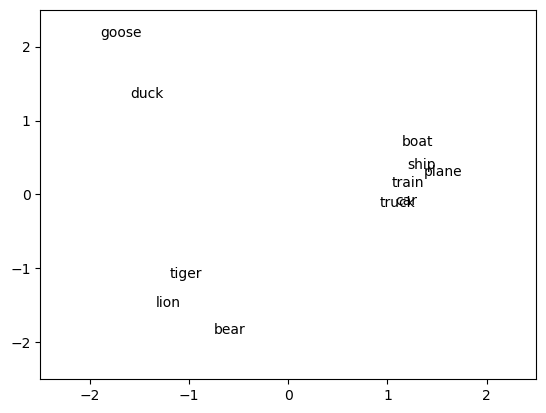

In [12]:
tokens = prompt.split(' ')[1:]
for i in range(len(tokens)):
    plt.text(coordinates[i,0],coordinates[i,1],tokens[i])
plt.xlim((-2.5,2.5))    
plt.ylim((-2.5,2.5))

### Expérience 2 : les relations sémantiques sont des relations spatiales

In [13]:
prompt = " France Paris Germany Berlin Italy Rome Spain Madrid Belgium Brussels"
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| France| -> 4881
| Paris| -> 6342
| Germany| -> 4486
| Berlin| -> 11307
| Italy| -> 8031
| Rome|  -> 10598
| Spain| -> 8602
| Madrid| -> 14708
| Belgium| -> 15664
| Brussels| -> 16445


In [14]:
embeddings=all_embeddings[input['input_ids'][0]]
embeddings = embeddings.cpu()
embeddings.shape

torch.Size([10, 768])

In [15]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(embeddings)

(-2.0, 2.0)

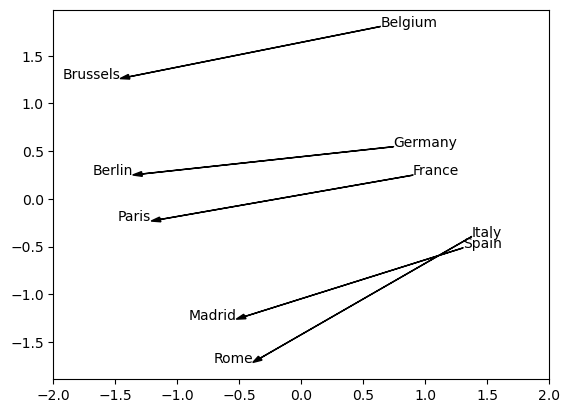

In [16]:
places = prompt.split(' ')[1:]
countries = [2*i for i in range(len(places)//2)]
cities = [2*i+1 for i in range(len(places)//2)]
for i in range(len(countries)):
    plt.arrow(coordinates[countries[i],0],coordinates[countries[i],1],coordinates[cities[i],0]-coordinates[countries[i],0],coordinates[cities[i],1]-coordinates[countries[i],1],color='black',head_width=0.05,length_includes_head=True)

for i,country in enumerate(countries):
    plt.text(coordinates[country,0],coordinates[country,1],places[country])
for i,city in enumerate(cities):
    plt.text(coordinates[city,0],coordinates[city,1],places[city], horizontalalignment='right')
plt.xlim((-2,2))

[comment]: <> "LTeX: language=fr"
## Positional encoding
Les mots d'un texte sont ordonnés. Lorsque nous entendons un texte, il n'y a pas d'ambiguité sur l'ordonnancement puisque les mots sont ordonnés dans le temps. Pour lire un texte, il est nécessaire d'avoir une convention sur la manière dont la disposition spatiale du texte représente son ordonnancement (par exemple, de gauche à droite et de bas en haut).

Les schémas que l'on utilise pour représenter graphiquement les modèles de langue pourraient nous laisser penser que l'ordonnancement des tokens est capturée par la topologie du réseau, les neurones "de gauche" représentant les premiers tokens et les neurones "de droite" les derniers. Il n'en est rien. Il n'y a pas de neurones "plus à gauche" que d'autres. La position des tokens doit donc être explicitée. 

Cette explicitation se fait avec un *positional encoding*, un vecteur de même dimension que l'embedding, qui code cette position. C'est la somme des deux vecteurs qui est donné au modèle, somme qui capture donc à la fois la sémantique et la position de chaque token.

### Expérience
On va visualiser, par réduction de dimensionnalité, les vecteurs de position de plusieurs tokens. Il n'est pas possible d'accéder directement à ces vecteurs $p_i$. En revanche, on peut accéder aux embeddings (vecteurs $e_i$) et aux entrées du réseau (vecteurs $x_{i,0}$). Sachant que, par définition, $x_{i,0} = e_i + p_i$, on peut reconstruire les vecteurs $p_i$ par : $p_i = x_{i,0} - e_i$ 

In [17]:
n_tokens=50
prompt = " test" * n_tokens # prompt = " test test test ....."
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332


[comment]: <> "LTeX: language=fr"
On génère 1 token (qui ne va pas nous intéresser puisque l'on veut regarder les entrées du modèle) en ajoutant 2 paramètres `return_dict_in_generate=True` et `output_hidden_states=True` qui indique au modèle de revoyer les états cachés. 

In [18]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1,
                       return_dict_in_generate=True, output_hidden_states=True)# ces deux paramètres font que le modèle renvoie les états cachés en plus de sa sortie

In [19]:
len(output['hidden_states'][0]) #L'indice 0 indique que l'on s'intéresse aux états cachés pour le 1er (et unique) token généré. On a 13 états cachés, un pour chaque couche ; 

13

[comment]: <> "LTeX: language=fr"
On s'intéresse au premier état caché, l'entrée du modèle, les vecteurs $x_{i,0}$ :

In [20]:
output['hidden_states'][0][0][0].shape #1er token, 1ère couche, 1ère sequence du batch -> matrice de n_tokens x dim_model

torch.Size([50, 768])

[comment]: <> "LTeX: language=fr"
On récupère les embeddings $e_i$ :

In [21]:
embeddings = all_embeddings[input['input_ids'][0]]
embeddings.shape

torch.Size([50, 768])

Les vecteurs de position sont définis par la différence entre les entrées et les embeddings : $p_i = x_{i,0} - e_i$ 

In [22]:
pos_enc = output['hidden_states'][0][0][0] - embeddings
pos_enc.shape

torch.Size([50, 768])

In [23]:
pos_enc = pos_enc.cpu()# on les rapatrie sur le CPU où seront faits la suite des calculs

In [24]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(pos_enc)
coordinates.shape

(50, 2)

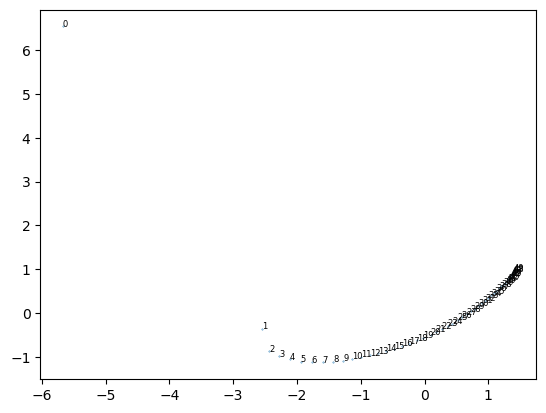

In [25]:
plt.scatter(coordinates[:,0],coordinates[:,1],s=.1)
for i in range(len(coordinates)):
    plt.text(coordinates[i,0],coordinates[i,1],str(i),fontsize=6)

[comment]: <> "LTeX: language=fr"
# Transformers

## Patterns attentionnels
Nous avons déjà vu que la bibliothèque [transformers](https://huggingface.co/docs/transformers/en/index) (on comprend à présent d'où vient son nom), nous permet d'accéder aux scores de sortie et aux états cachés. On peut également accéder aux scores d'attention $att_i$ (en revanche, on n'a pas accès aux vecteurs $q$, $k$ et $v$). Nous allons utiliser la bibliotèque [BertViz](https://github.com/jessevig/bertviz) pour visualiser ces scores d'attention. Celà nous permettra d'observer comment l'information circule de token en token, couche après couche. 

In [26]:
#prompt = "Now that the model is loaded, let's use it"
#prompt = "The model is loaded, let's use it"
#prompt = "I read the book and I liked it"
prompt = "I read the book and I didn't like it"
#prompt = "I've met your friend and I don't like him"

In [27]:
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')
tokens = [tokenizer.decode(token) for token in input['input_ids'][0]]

|token|  -> id

|I|      -> 40
| read|  -> 1100
| the|   -> 262
| book|  -> 1492
| and|   -> 290
| I|     -> 314
| didn|  -> 1422
|'t|     -> 470
| like|  -> 588
| it|    -> 340


In [28]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1,
                          return_dict_in_generate=True, output_hidden_states=True, output_attentions=True) #on a ajouté le paramètre output_attentions=True

In [29]:
len(output['attentions'][0]) #L'indice 0 indique que l'on s'intéresse aux attentions calculées pour le 1er (et unique) token généré. On a 12 matrices (tenseurs) d'attention, une pour chaque couche ;

12

In [30]:
output['attentions'][0][0].shape #1er token généré, 1ère couche -> matrice de taille du batch x n_heads x n_tokens x n_tokens

torch.Size([1, 12, 10, 10])

In [31]:
print(f"Chaque couche est composée de {gpt2.config.n_head} têtes d'attention.")

Chaque couche est composée de 12 têtes d'attention.


In [32]:
#attention = output['attentions'][0]

In [33]:
model_view(output['attentions'][0], tokens) 

<IPython.core.display.Javascript object>

Quelques remarques sur a la visualisation ci-dessus : 
* Couche 3, tête 6 : les verbes portent leur attention vers leur sujet
* Couche 4, tête 3 : les pronoms portent leur attention vers leur antécédant
 

## Représentations

Essayons de regarder de plus près les états cachés (residual stream)

<img src="https://raw.githubusercontent.com/jmague/formation_LLM_IXXI/master/img/images/images.003.png" width="200">

In [29]:
prompt = "I read the book and I didn't like"
#prompt = "Alice and Bob went to the park. Bob gave Alice a flower. Alice thanked"
input = tokenizer(prompt, return_tensors="pt").to(device)
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1,
                          return_dict_in_generate=True, output_hidden_states=True, output_scores=True) 

In [30]:
print(f'input : {prompt}')
print(f'output: {tokenizer.decode(output["sequences"][0])}')

input : I read the book and I didn't like
output: I read the book and I didn't like it


[comment]: <> "LTeX: language=fr"
##### Scores et probabilités associés au dernier token, sur la dernière couche :
Cela revient à refaire ce que l'on a fait dans le premier notebook, sauf qu'au lieu de récupérer directement les scores, on va récupérer le dernier état caché et faire l'unembedding manuellement :

<img src="https://raw.githubusercontent.com/jmague/formation_LLM_IXXI/master/img/images/images.004.png" width="200">

In [8]:
generated_token = 0
layer = 12
n_batch = 0
token_position = -1
last_hidden_state = output['hidden_states'][generated_token][layer][n_batch][token_position]

In [15]:
unembedding = gpt2.lm_head.forward(last_hidden_state)
unembedding

tensor([ -99.0602,  -98.8477, -105.6298,  ..., -106.0685, -108.0961,
        -100.8393], device='mps:0')

On peut vérifier que l'on trouve bien les scores : 

In [18]:
output['scores'][0]

tensor([[ -99.0602,  -98.8477, -105.6298,  ..., -106.0685, -108.0961,
         -100.8393]], device='mps:0')

On peut, comme dans le premier notebook, en déduire les probabilités. On note que c'est bien le token ayant la plus grande probabilité qui a été généré

In [21]:
probs_after_last_layer = torch.nn.functional.softmax(unembedding, dim=0).cpu()
prob_of_each_token_after_last_layer = list(zip([tokenizer.decode(i) for i in range(50257)], probs_after_last_layer))
sorted(prob_of_each_token_after_last_layer,key=lambda x:x[1],reverse=True)[:5]

[(' it', tensor(0.6465)),
 (' the', tensor(0.1365)),
 (' what', tensor(0.0412)),
 (' that', tensor(0.0273)),
 (' how', tensor(0.0272))]

[comment]: <> "LTeX: language=fr"
##### Que ce se passe-t-il si l'on fait l'unembedding juste avant la dernière couche ?
Se pourrait-il que l'avant-dernier état caché commporte déjà suffisament d'information pour prédire le prochain token ? 

<img src="https://raw.githubusercontent.com/jmague/formation_LLM_IXXI/master/img/images/images.005.png" width="200">

In [14]:
generated_token = 0
layer = 11 #on regarde la couche 11
n_batch = 0
token_position = -1
hidden_state = output['hidden_states'][generated_token][layer][n_batch][token_position]

In [15]:
unembedding = gpt2.lm_head.forward(hidden_state)

In [16]:
probs = torch.nn.functional.softmax(unembedding, dim=0).cpu()
prob_of_each_token = list(zip([tokenizer.decode(i) for i in range(50257)], probs))
sorted(prob_of_each_token,key=lambda x:x[1],reverse=True)[:5]

[(' the', tensor(1.)),
 (' it', tensor(5.5997e-14)),
 (',', tensor(4.9511e-29)),
 (' that', tensor(3.1386e-33)),
 ('.', tensor(1.8974e-34))]

[comment]: <> "LTeX: language=fr"
Le token finalement choisi n'est pas encore prédictible. 

[comment]: <> "LTeX: language=fr"
##### Que ce se passe-t-il si l'on fait l'unembedding à partir sur le premier état caché ?
Aucune chance qu'il prédise le prochain token, puisqu'aucun traitement n'a encore été fait... 

<img src="https://raw.githubusercontent.com/jmague/formation_LLM_IXXI/master/img/images/images.006.png" width="200">

In [39]:
generated_token = 0
layer = 0 #on regarde la couche 0, c'est a dire l'entrée du modèle
n_batch = 0
token_position = -1
hidden_state = output['hidden_states'][generated_token][layer][n_batch][token_position]

In [40]:
unembedding = gpt2.lm_head.forward(hidden_state)

In [41]:
probs = torch.nn.functional.softmax(unembedding, dim=0).cpu()
prob_of_each_token = list(zip([tokenizer.decode(i) for i in range(50257)], probs))
sorted(prob_of_each_token,key=lambda x:x[1],reverse=True)[:5]

[(' like', tensor(0.0086)),
 (' LIKE', tensor(0.0022)),
 ('like', tensor(0.0021)),
 (' Like', tensor(0.0010)),
 ('Like', tensor(0.0007))]

Sans surprise (quoi que) l'unembedding de l'entrée du réseau donne le token d'entrée

#### Essayons pour toutes les couches

In [20]:
generated_token = 0
n_batch = 0
token_position = -1
for layer in range(gpt2.config.n_layer+1):
    print(f'layer {layer}')
    hidden_state = output['hidden_states'][generated_token][layer][n_batch][token_position]
    unembedding = gpt2.lm_head.forward(hidden_state)
    probs = torch.nn.functional.softmax(unembedding, dim=0).cpu()
    prob_of_each_token = list(zip([tokenizer.decode(i) for i in range(50257)], probs))
    for token, prob in sorted(prob_of_each_token,key=lambda x:x[1],reverse=True)[:3]:
        print(f'{prob:.4f} -> {token}')
    print('\n----------------\n')
    

layer 0
0.2700 ->  thanked
0.0075 ->  thanking
0.0059 ->  congratulated

----------------

layer 1
0.8001 -> ,
0.1667 ->  the
0.0250 -> .

----------------

layer 2
0.5557 ->  the
0.4197 -> ,
0.0136 -> .

----------------

layer 3
0.7417 ->  the
0.2548 -> ,
0.0023 -> .

----------------

layer 4
0.8970 ->  the
0.1025 -> ,
0.0003 -> .

----------------

layer 5
0.8599 ->  the
0.1400 -> ,
0.0001 ->  a

----------------

layer 6
0.9862 ->  the
0.0137 -> ,
0.0001 ->  a

----------------

layer 7
1.0000 ->  the
0.0000 -> ,
0.0000 ->  a

----------------

layer 8
1.0000 ->  the
0.0000 -> ,
0.0000 ->  a

----------------

layer 9
1.0000 ->  the
0.0000 -> ,
0.0000 ->  him

----------------

layer 10
1.0000 ->  the
0.0000 -> ,
0.0000 ->  him

----------------

layer 11
1.0000 ->  the
0.0000 -> ,
0.0000 ->  and

----------------

layer 12
0.4988 ->  Bob
0.1839 ->  him
0.1229 ->  her

----------------

